#### **Project Overview**

The goal of this project is to segment customers into distinct groups based on their purchasing behavior, using unsupervised learning techniques such as K-means clustering or hierarchical clustering. This will help businesses tailor marketing strategies, improve customer retention, and optimize resource allocation.

This project will demonstrate your skills in:
- Data cleaning and preprocessing
- Exploratory data analysis (EDA)
- Feature engineering
- Unsupervised machine learning (clustering)
- Visualization and storytelling

---


In [24]:
# Import the necessary libraries for the Project

import pandas as pd

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

from scipy.spatial.distance import cdist


---


In [10]:
# Import the document, in this case is a .xlsx

df = pd.read_excel('online_retail.xlsx', parse_dates=['InvoiceDate'])

df.head()           # I check the head of the file to verify that it was uploaded properly

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


---

In [11]:
# Verify for null values on the dataset

df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

**Note:**

It's clear that there are 1454 null values in <code> 'Description'</code> , and 135080 in <code> 'CustomerID'</code> 

---


In [ ]:
df = df.dropna(subset = ['CustomerID'])         # Here I delete the rows that contain null values in the feature 'CustomerID'
df = df.drop(columns = ['Description'])         # Here I delete the 'Description' feature as in this case it won't help to cluster

---

In [19]:
# Here I verify for repeated values, that make reference to the same country in the 'Country' feature.

df['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

**Note:** 

In this case there are no repeated values like ones I explained in my comments of the previous cell. That's why there is no need to do anything. But in some cases when the repeated values are found is important to convert all the different values that refer to the same country to only one value. 

ex: If values like USA / US / United States are found in the same dataset, then I would need to convert all the values to only one so there will only one value referencing the same country. 

---

Now it's time to search for negative values in rows where the value should be positive. In this case i chooses the features <code>'Quantity'</code> and <code> 'UnitPrice'</code> 


In [ ]:
positive_values_verification = ['Quantity', 
                               'UnitPrice']         # Here I specify the columns I want to check for negative values to create a loop

for col in positive_values_verification:             # This is the loop, where it is going through each element in the variable 'positive_values_verification',
    verify = df[df[col] < 0]                        # then search for negative values on them,
    print(f"Number of negative values in {col}: {len(verify)}")         # and finally it prints out the amount of negative values in each element

Number of negative values in Quantity: 8905
Number of negative values in UnitPrice: 0


---

In [21]:
# Handle the negative values in Quantity

df = df[df['Quantity'] > 0]


**Note:**

While I could keep the negative values on both features and categorize them as returns (or other feature) I prefer to keep the clustering simple. In the future I will update the project to include the return and make a new analysis. As I consider is a very important variable to understand customer behavior.  

---

To do the RFM analysis it's important to find the most recent date in which there was a sell.

In [22]:
recency = df['InvoiceDate'].max() + pd.Timedelta(days = 1)          # This line helps me to find the most recent date using .max, then I proceed to add a day to it so the most recent sells will not have a count of 0 but of 1
print(f"Reference Date: {recency}")                                 # Here I just print the date of reference


Reference Date: 2011-12-10 12:50:00


---

I got the reference date for Recency, so I can start to make the RFM analysis

In [ ]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (recency - x.max()).days,              # Recency
    'InvoiceNo': 'nunique',                                         # Frequency
    'UnitPrice': lambda x: (x * df.loc[x.index, 'Quantity']).sum()  # Monetary
}).rename(columns = {
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'UnitPrice': 'Monetary'
})

# Reset the index to make CustomerID a column

rfm = rfm.reset_index()

**Note:**

I created the rfm as a data frame clarifying what to do on each feature using operations with lambda  for Recency and Monetary, and nunqiue for the Frequency

---

In [25]:
# Apply log transformation to reduce skewness

rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log1p)

# Scale the data

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# Convert back to dataframe for easier interpretation

rfm_scaled_df = pd.DataFrame(rfm_scaled, columns = ['Recency', 'Frequency', 'Monetary'], index = rfm.index)

---

In [26]:


inertia = []                                # Elbow method by Inertia
distortions = []                            # Elbow method by Distortion
inertia_dict = {}                           # Create an Inertia dictionary to store the Inertia Values
distortions_dict = {}                       # Create an Distortions dictionary to store the Distortion Values
K = range(1, 11)                            # Define the range to explore k

# Fit K-means for different values of k

for k in K:                                 # Testing cluster for the range in K
    kmeans = KMeans(n_clusters=k, random_state=69).fit(rfm_scaled_df)
    inertia.append(kmeans.inertia_)
    distortions.append(sum(np.min(cdist(rfm_scaled_df, kmeans.cluster_centers_, 'euclidean'), axis=1)**2) / rfm_scaled_df.shape[0])         # Calculate distortion as the average squared distance from points to their cluster centers
    inertia_dict[k] = inertia[-1]           # Store Inertia for easy access
    distortions_dict[k] = distortions[-1]   # Store Distortions for easy access

---

Inertia values:
1: 13017.000000000004
2: 6493.017307981491
3: 4881.0808582337095
4: 3953.0077265394193
5: 3311.6721044397154
6: 2870.6730855550477
7: 2567.080535722069
8: 2358.1499584395233
9: 2219.2970904396925
10: 2070.968372498207


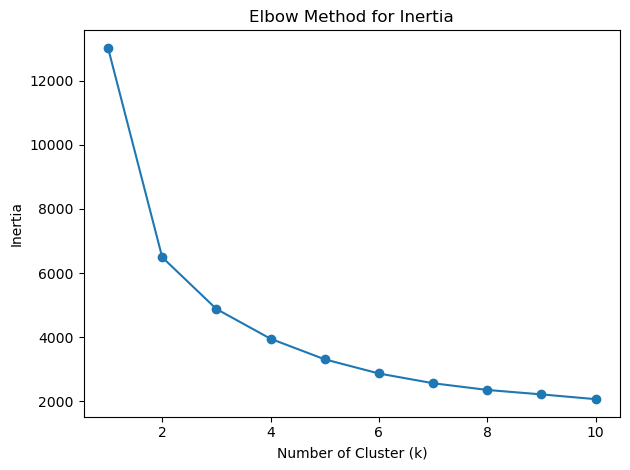

In [30]:
# Display Inertia values

print("Inertia values:")
for key, value in inertia_dict.items():
    print(f"{key}: {value}")

    # Plot the elbow curve to identify the optimal k

plt.plot(K, inertia, marker='o')
plt.xlabel('Number of Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Inertia')
plt.tight_layout()
plt.show()

Distortions Values:
1: 2.999999999999997
2: 1.4964317372623834
3: 1.1249322097796037
4: 0.9110411907212287
5: 0.7632339489374798
6: 0.6615978533199001
7: 0.5916295311643396
8: 0.5434777502741475
9: 0.5114766283566934
10: 0.4772916276787737


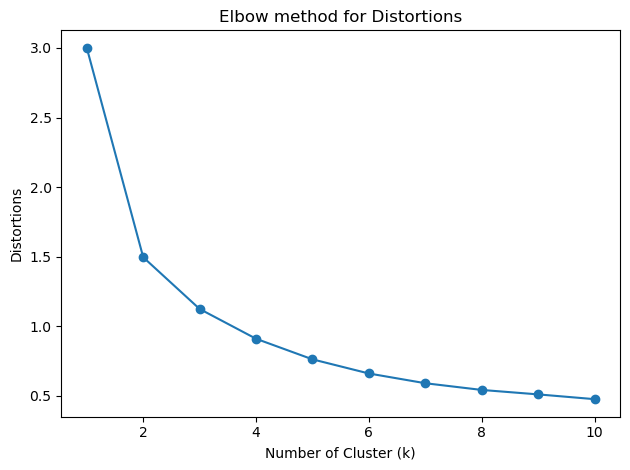

In [29]:
# Display Distortions values

print("Distortions Values:")
for key, value in distortions_dict.items():
    print(f"{key}: {value}")
    
    # Plot the elbow curve to identify the optimal k

plt.plot(K, distortions, marker='o')
plt.xlabel('Number of Cluster (k)')
plt.ylabel('Distortions')
plt.title("Elbow method for Distortions")
plt.tight_layout()
plt.show()


---

A silhouette analysis might be helpful to find teh right k value to cluster 

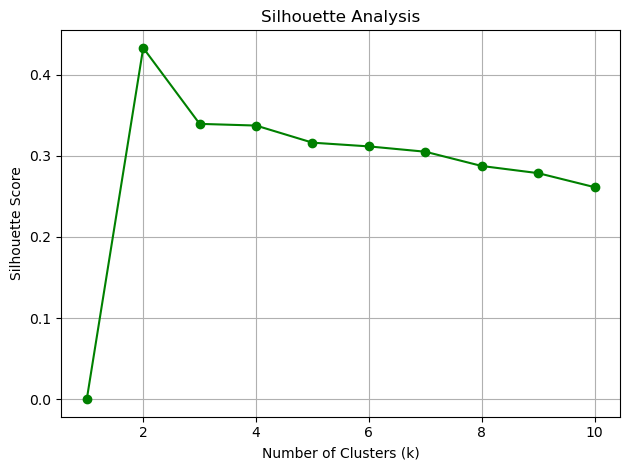

In [31]:
silhouette_scores = []

for k in K:
    if k > 1:                                                                       # Silhouette Score requires at least 2 clusters
        kmeans = KMeans(n_clusters=k, random_state=69).fit(rfm_scaled_df)
        score = silhouette_score(rfm_scaled_df, kmeans.labels_)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(0)                                                 # No score for k=1

# Plot Silhouette Scores

plt.plot(K, silhouette_scores, marker='o', label='Silhouette Score', color='green')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.grid(True)
plt.tight_layout()
plt.show()

---

From all the previous visual analysis it seems like the proper number of cluster should be 2, but the number displayed in the Distortion seem to me that it could also be 3 or 4.

For the sake of teh project I decided to run one more visualization based on the Calinski Harabasz Analysis 

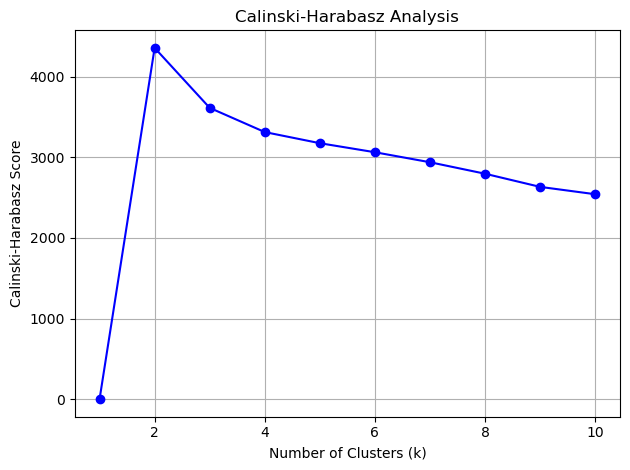

In [32]:


ch_scores = []
for k in K:
    if k > 1:
        kmeans = KMeans(n_clusters=k, random_state=69).fit(rfm_scaled_df)
        score = calinski_harabasz_score(rfm_scaled_df, kmeans.labels_)
        ch_scores.append(score)
    else:
        ch_scores.append(0)

plt.plot(K, ch_scores, marker='o', label='Calinski-Harabasz Score', color='blue')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Analysis')
plt.grid(True)
plt.tight_layout()
plt.show()

**Note:**

Again the peak is 2 (k=2), but again I consider that 2 might be too narrow and based on the number of teh Distortion I choose 3 (I didn't choose 4 as it could be already to far from the original peak (2)) to be able to expand further the customer analysis and provide more granular insights

---

In [33]:
# Apply K-means with k=3

kmeans3 = KMeans(n_clusters=3, random_state=69)
rfm['Cluster'] = kmeans3.fit_predict(rfm_scaled_df)

# Calculate the mean RFM values for each cluster

cluster_profiles = rfm.groupby('Cluster').mean()[['Recency', 'Frequency', 'Monetary']]
cluster_profiles

,Recency,Frequency,Monetary
Cluster,,,
0,14.721763,13.768595,8096.377782
1,164.052522,1.357774,365.041228
2,44.542012,3.508284,1379.564114


---

After creating the clusters and extracting relevant info from each one, I started to create visualizations for an an easier understanding.

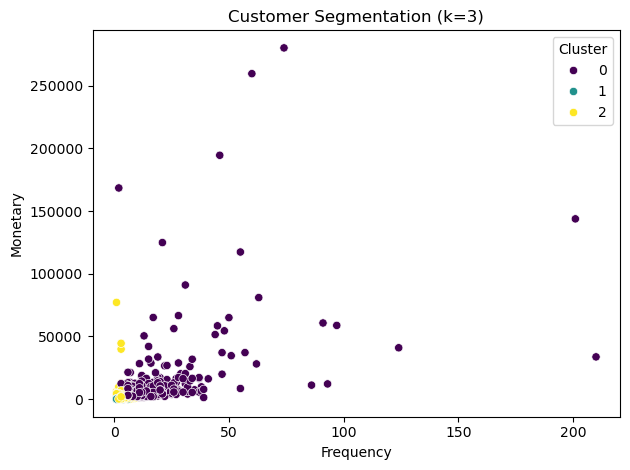

In [35]:
# Scatter plot (Frequency vs. Monetary)
sns.scatterplot(
    data=rfm, 
    x = 'Frequency', 
    y = 'Monetary', 
    hue = 'Cluster', 
    palette = 'viridis')
plt.title('Customer Segmentation (k=3)')
plt.tight_layout()          # I just use this because I like more the clean format with good space
plt.show()

---

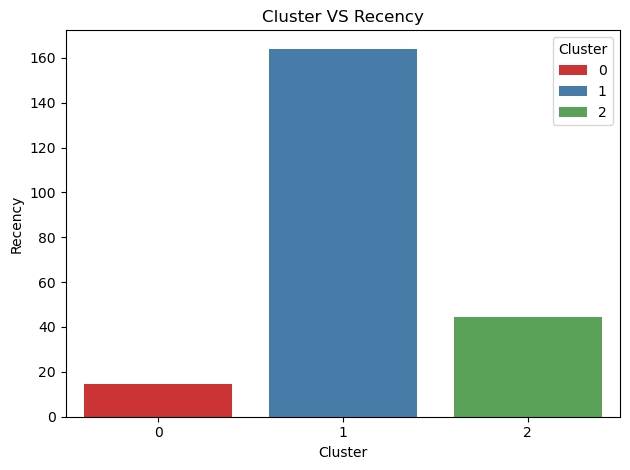

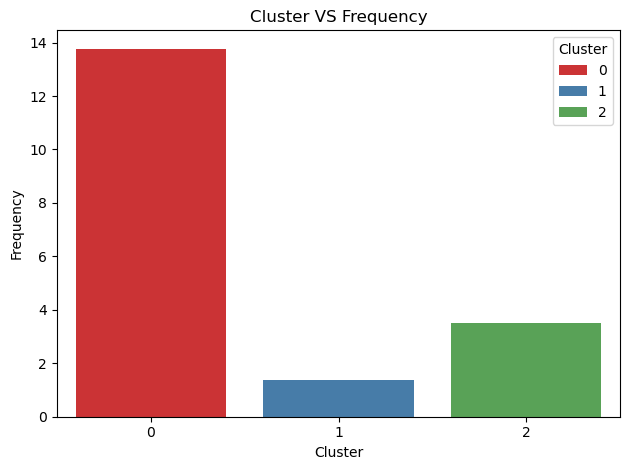

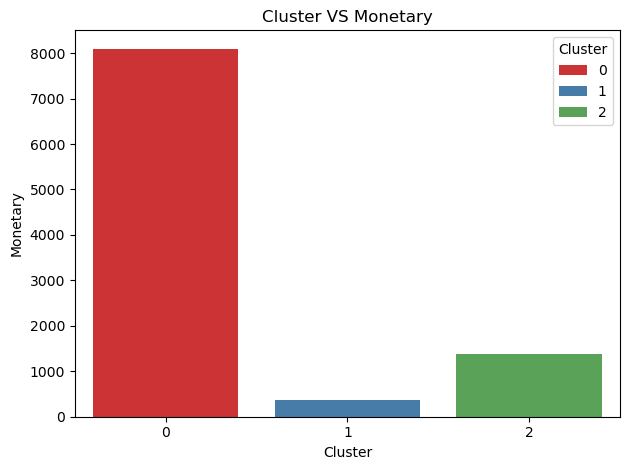

In [36]:
cluster_profiles_features = ["Recency", "Frequency", "Monetary"]        # Here I define the features to loop

for col in cluster_profiles:        # This is the start of the loop, in this case the loop helps to save time and lines of code
    sns.barplot(
        data = cluster_profiles,
        x = 'Cluster',
        y = col,
        hue = 'Cluster',
        palette = 'Set1'
    )
    plt.title(f'Cluster VS {col}')
    plt.tight_layout()
    plt.show()

---


**IMPORTANT:**

Find the analysis in the file under the name <code>'analysis.md'</code>


---

### About the Author

**Name:** Sebastian Mondragon  

- **Email:** basmondragon@proton.me
- **Telegram:** [https://t.me/basmondragon](https://t.me/basmondragon)
- **LinkedIn:** [https://www.linkedin.com/in/basmondragon/](https://www.linkedin.com/in/basmondragon/)

#### Skills

- **Programming Languages:** Python, SQL  
- **Libraries & Frameworks:** Pandas, NumPy, Scikit-learn, Matplotlib, Seaborn, XGBoost  
- **Methodologies:** Data Cleaning, Feature Engineering, Machine Learning, Model Evaluation  
- **Soft Skills:** Problem-Solving, Analytical Thinking, Communication  

#### Acknowledgments

This project was inspired by my passion for applying machine learning to solve business challenges.

#### Next Steps

If you have any feedback or suggestions for improving this project, feel free to reach out to me via email or LinkedIn. I’m always open to learning and collaborating on new ideas!  

Feel free to explore my other projects on GitHub: [https://github.com/basmondragon](https://github.com/basmondragon)

---

#### Citations

Chen, D. (2015). Online Retail [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5BW33.